In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

In [2]:
cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'session_seen', 'session_correct', 'avg_user_p_recall', 'ui_language', 'learning_language']
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')
dff.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [3]:
dff.columns

Index(['gender', 'def', 'tense', 'POS', 'person', 'number', 'word_len',
       'tags_list', 'SUBTLEX', 'p_recall', 'delta', 'history_seen',
       'history_correct', 'h_recall', 'lang_combination', 'avg_delta',
       'std_delta', 'avg_h_recall'],
      dtype='object')

In [4]:
# Handle tags 
# 1) Store tags as list, but delete rows where there are less than x occurences 
dff_1 = dff.copy()
tag_counts = dff_1['tags_list'].value_counts()
rare_threshold = 1000
dff_1['tags_list'] = dff_1['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')

dff_1.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True)
dff_1.dropna(inplace=True)

# 2) Store each tag as column, replace NaN values with a placeholder for categorical columns
# categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()
# dff_2 = dff.copy()
# dff_2[categorical_cols] = dff_2[categorical_cols].fillna('missing')
# dff_2.drop(columns=['tags_list'], inplace=True)

In [7]:
# VIF -> iteratevily delete columns that had VIF > 10
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
    
dff_VIF = dff_1.drop(columns=['p_recall','history_correct', 'history_seen']).sample(2000000)
vif = calculate_vif(dff_VIF.select_dtypes(exclude='O'))
vif

,Feature,VIF
0,word_len,7.946208
1,SUBTLEX,1.429122
2,delta,1.982892
3,h_recall,51.055735
4,avg_delta,4.075180
5,std_delta,3.824515
6,avg_h_recall,59.558585


In [8]:
removed_features = ["avg_h_recall", 'history_correct']
correlation_with_target = dff_1[removed_features + ["p_recall"]].corr()["p_recall"]
print(correlation_with_target)

avg_h_recall       0.164711
history_correct    0.000409
p_recall           1.000000
Name: p_recall, dtype: float64


In [9]:
dff_final = dff_1.sample(frac=0.7)
# dff_final = dff_2

In [10]:
# Transforming skewed variables
dff_final['history_wrong'] = np.log2(1+(dff_final['history_seen']-dff_final['history_correct']))
dff_final['delta'] = np.sqrt(dff_final['delta']/(60*60*24))
dff_final['avg_delta'] = np.sqrt(dff_final['avg_delta']/(60*60*24))
dff_final['history_seen'] = np.log2(1+dff_final['history_seen'])
dff_final['history_correct'] = np.log2(1+dff_final['history_correct'])
dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

In [11]:
dff_final[['word_len', 'SUBTLEX', 'delta', 'history_seen', 'history_correct', 'h_recall', 'std_delta', 'avg_h_recall', 'history_wrong', 'avg_delta', 'p_recall']].corr()['p_recall'].sort_values()

history_wrong     -0.080387
delta             -0.040353
avg_delta         -0.032428
std_delta         -0.021554
SUBTLEX           -0.011600
history_seen      -0.004059
history_correct    0.011812
word_len           0.015466
h_recall           0.104019
avg_h_recall       0.164850
p_recall           1.000000
Name: p_recall, dtype: float64

In [12]:
# Transformation of target variable 

# Logit transformation 
def logit_transform(y, epsilon=1e-10):
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

def inverse_logit_transform(y):
    return 1 / (1 + np.exp(-y))


# Log transformation 
def log_transform(y, epsilon=1e-10):
    return np.log(y + epsilon)

def inverse_log_transform(y):
    return np.exp(y)


# Box-Cox transformation
power_transformer = PowerTransformer(method='box-cox', standardize=False)
def power_transform(y, epsilon=1e-10):
    return power_transformer.fit_transform(y+epsilon) 

def inverse_power_transform(y, epsilon=1e-10):
    return power_transformer.inverse_transform(y+epsilon) 

In [13]:
# Create df without word features 
# dff_t = dff_final.drop(columns=['tags_list', 'word_len', 'SUBTLEX'], errors='ignore')

# df without SUBTLEX
# dff_t = dff_final.drop(columns=['SUBTLEX'], errors='ignore')

# DF original 
# dff_s = dff_final.drop(columns=['SUBTLEX', 'tags_list', 'word_len', 'avg_delta', 'std_delta', 'avg_h_recall', 'lang_combination', 'h_recall'], errors='ignore')

# DF without history correct and seen
# dff_s = dff_final.drop(columns=['history_correct', 'history_seen'], errors='ignore')

# DF without user columns 
# dff_u = dff_final.drop(columns=['avg_delta', 'std_delta', 'avg_h_recall', 'h_recall'], errors='ignore')

# DF without lang ui and lang native
# dff_u = dff_final.drop(columns=['ui_language', 'learning_language'], errors='ignore')


In [14]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded

In [15]:
def split_dataset(df):
    X = df.drop(columns='p_recall')
    y = df['p_recall']
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

In [16]:
def cap_y(prediction): 
    return np.clip(prediction, 0, 1)

In [47]:
dff_encoded = ohe(dff_final.sample(frac=0.1))
# dff_t_encoded = ohe(dff_t)
# dff_s_encoded = ohe(dff_s)
# dff_u_encoded = ohe(dff_u)


X_train, X_test, y_train, y_test = split_dataset(dff_encoded)
# X_train_t, X_test_t, y_train_t, y_test_t = split_dataset(dff_t_encoded)
# X_train_s, X_test_s, y_train_s, y_test_s = split_dataset(dff_s_encoded)
# X_train_u, X_test_u, y_train_u, y_test_u = split_dataset(dff_u_encoded)

In [48]:
def create_pipeline(model_type="linear"):
    """
    Create a pipeline for regression with optional feature selection.
    
    Returns:
    - Pipeline object
    """
    if model_type == "ridge":
        model = Ridge(alpha=0.1, fit_intercept=True)
    else:
        model = LinearRegression()

    steps = [
        ('scaler', StandardScaler()),
        # ('polynomial_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('model', model)
        # ('model', TransformedTargetRegressor(regressor=model, 
        #                                     func=log_transform,
        #                                     inverse_func=inverse_log_transform))
    ]
    return Pipeline(steps)

In [67]:
def train_predict(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)


    y_train_pred = cap_y(pipeline.predict(X_train))
    y_test_pred = cap_y(pipeline.predict(X_test)) 

    return y_train_pred, y_test_pred

In [70]:
# Define Configurations for Pipelines
def regression_results(X_train, X_test, y_train, y_test, importance='No'):
    
    pipeline = create_pipeline()
    y_train_pred, y_test_pred = train_predict(pipeline, X_train, X_test, y_train, y_test)
    
    # Calculate metrics 
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    print(f"Train R2 = {round(train_r2, 4)}, Test R2 = {round(test_r2,4)}, Train MAE = {round(train_mae,4)}, Test MAE = {round(test_mae, 4)}")

    
    if isinstance(importance, str) and importance == 'Yes':
        model = pipeline.named_steps["model"]
        coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})

    print('Intercept:', model.intercept_)
    
    full_df = X_test.copy()
    full_df['predictions'] = y_test_pred
    full_df['p_recall'] = y_test

    return coefficients_df, full_df

In [72]:
print('Results for all features')
importance_df, full_df = regression_results(X_train, X_test, y_train, y_test, importance='Yes')

# print('Results after deleting word features')
# results_t, importance_t, full_df_t = regression_results(pipelines_config, X_train_t, X_test_t, y_train_t, y_test_t, importance='Yes')

# print('Results without word and user features')
# results_s, importance_s, full_df_s  = regression_results(pipelines_config, X_train_s, X_test_s, y_train_s, y_test_s, importance='Yes')

# print('Results without user features') 
# results_u, importance_u, full_df_u = regression_results(pipelines_config, X_train_u, X_test_u, y_train_u, y_test_u, importance='No')

Results for all features
Train R2 = 0.0282, Test R2 = 0.0304, Train MAE = 0.164, Test MAE = 0.1611
Intercept: 0.8964782335191402


In [75]:
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)
importance_df

,Feature,Coefficient
4,history_correct,0.335670
8,avg_h_recall,0.033753
55,"tags_list_['n', 'f', 'sg']",0.003017
139,"tags_list_['vblex', 'pri', 'p1', 'sg']",0.003006
115,"tags_list_['vbdo', 'pres']",0.002492
...,...,...
2,delta,-0.006685
1,SUBTLEX,-0.010592
9,history_wrong,-0.010820
5,h_recall,-0.042822


<Axes: >

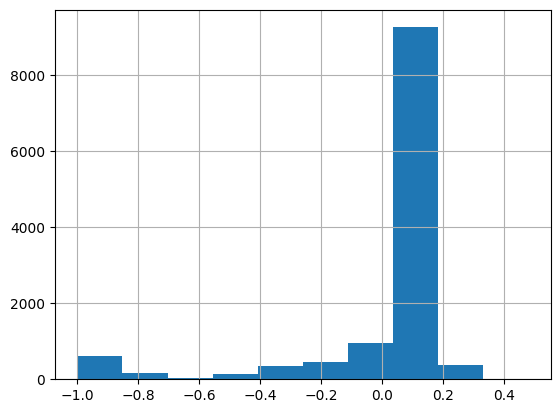

In [76]:
# Examine residuals 
full_df_all['diff'] = full_df_all['p_recall'] - full_df_all['predictions']
full_df_all['diff'].hist()

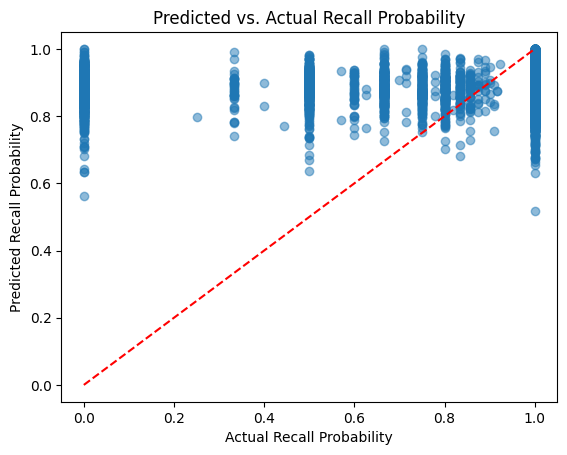

In [78]:
# Predictions vs actual recall probabilities 
plt.scatter(full_df_all['p_recall'], full_df_all['predictions'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
plt.show()

In [89]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
full_df_all.loc[:, ~full_df_all.columns.str.startswith(('lang_combination', 'tags_list'))].describe()

,word_len,SUBTLEX,delta,history_seen,history_correct,h_recall,avg_delta,std_delta,avg_h_recall,history_wrong,predictions,p_recall,diff
count,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000,12319.00000
mean,4.05975,2178695.40847,1.42475,3.59626,3.44314,0.89316,1.91999,476439.47557,0.89668,1.07377,0.89680,0.89887,0.00207
std,1.74522,3681894.15183,1.77473,1.37459,1.38794,0.12587,1.33314,562989.34751,0.04943,1.05247,0.04524,0.26168,0.25924
min,1.00000,1271.00000,0.01179,1.00000,1.00000,0.10000,0.02442,0.00000,0.52778,0.00000,0.51896,0.00000,-1.00000
25%,3.00000,19849.00000,0.07561,2.58496,2.32193,0.83333,0.99102,101231.97450,0.87188,0.00000,0.87123,1.00000,0.04623
50%,4.00000,143725.00000,0.88911,3.45943,3.32193,0.92593,1.61801,255272.42207,0.90240,1.00000,0.90043,1.00000,0.08651
75%,5.00000,3122198.00000,2.07153,4.45943,4.32193,1.00000,2.53352,651463.87559,0.92896,1.58496,0.92690,1.00000,0.11823
max,11.00000,14459520.00000,9.28304,8.64386,8.46352,1.00000,9.19604,3710308.46937,1.00000,6.80735,1.00000,1.00000,0.48104


In [98]:
full_df_all['p_recall'].value_counts(normalize=True)

p_recall
1.00000   0.82661
0.00000   0.06380
0.50000   0.03361
0.66667   0.02200
0.75000   0.01664
0.80000   0.01567
0.83333   0.00722
0.85714   0.00341
0.60000   0.00317
0.33333   0.00292
0.87500   0.00122
0.88889   0.00089
0.71429   0.00049
0.77778   0.00041
0.90000   0.00041
0.90909   0.00032
0.62500   0.00024
0.91667   0.00016
0.40000   0.00016
0.81818   0.00016
0.57143   0.00016
0.92308   0.00008
0.44444   0.00008
0.25000   0.00008
0.70000   0.00008
Name: proportion, dtype: float64

In [99]:
full_df_all['predictions'].value_counts(normalize=True)

predictions
1.00000   0.00511
0.86590   0.00008
0.93761   0.00008
0.86789   0.00008
0.90563   0.00008
            ...  
0.92146   0.00008
0.97093   0.00008
0.82880   0.00008
0.92189   0.00008
0.85528   0.00008
Name: proportion, Length: 12257, dtype: float64

In [31]:
full_df_all[['p_recall', 'predictions']]

,p_recall,predictions
682558,1.00000,0.92015
8361663,1.00000,0.89149
82599,1.00000,0.91163
2912238,0.66667,0.89200
1253433,0.66667,0.91065
...,...,...
1936760,0.75000,0.85052
6656859,1.00000,0.91963
1662334,1.00000,0.91856
2991749,1.00000,0.91069


<Axes: >

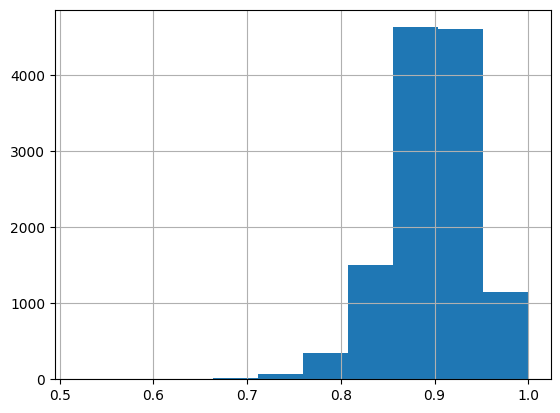

In [80]:
full_df_all['predictions'].hist()

<Axes: >

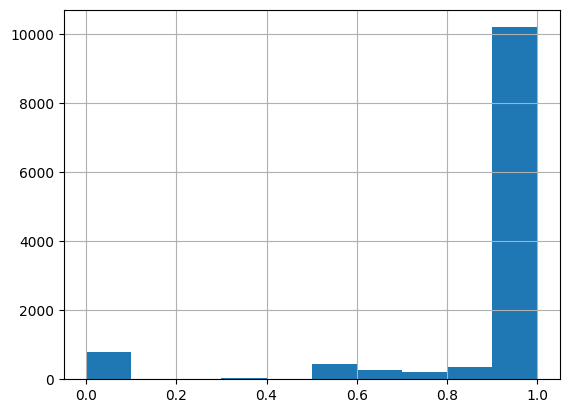

In [81]:
full_df_all['p_recall'].hist()